In [1]:
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline
# import pdb

In [1]:
import os
import os.path as op
import time
import argparse
from glob import glob
from data.data_pipe import get_val_pair
from torchvision import transforms as trans
from tqdm import tqdm_notebook as tqdm
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from Learner import face_learner
from config import get_config
from utils import hflip_batch, cosineDim1
from data.datasets import (IJBCAllCroppedFacesDataset, IJBCVerificationPathDataset,
                           ARVerificationAllPathDataset, IJBAVerificationDataset)
from verification import calculate_val_by_diff, calculate_val_far

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Init Learner and conf

In [2]:
conf = get_config(training=False)
conf.batch_size=20 # Why bs_size can only be the number that divide 6000 well?
learner = face_learner(conf, inference=True)

{'fixed_str': 'ir_se50.pth', 'pretrainedMdl': 'ir_se50.pth', 'data_path': PosixPath('data'), 'work_path': PosixPath('work_space'), 'model_path': PosixPath('work_space/models'), 'log_path': PosixPath('work_space/log'), 'save_path': PosixPath('work_space/save'), 'exp_title': 'xCos', 'exp_comment': 'expMS1M', 'input_size': [112, 112], 'embedding_size': 1568, 'use_mobilfacenet': False, 'net_depth': 50, 'drop_ratio': 0.6, 'net_mode': 'ir_se', 'device': device(type='cuda', index=0), 'test_transform': Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
), 'data_mode': 'emore', 'vgg_folder': PosixPath('data/faces_vgg_112x112'), 'ms1m_folder': PosixPath('data/faces_ms1m_112x112'), 'emore_folder': PosixPath('data/faces_emore'), 'batch_size': 20, 'USE_SOFTMAX': True, 'SOFTMAX_T': 1, 'facebank_path': PosixPath('data/facebank'), 'threshold': 1.5, 'threshold_xCos': 0.2338, 'face_limit': 10, 'min_face_size': 30}
ir_se_50 model generated


In [3]:
def l2normalize(x, ord=2, axis=None):
    return x / np.linalg.norm(x, ord=ord, axis=axis)


def score_fn_original(feat1, feat2):
    return l2normalize(feat1).dot(l2normalize(feat2))
    

def score_fn_ours(feat_map1, feat_map2, learner, attention_strategy='learned', attention_weight=None):
    with torch.no_grad():
        assert len(feat_map1.shape) == 3  # [c, w, h]
        c, w, h = feat_map1.shape
        feat_map1 = torch.tensor(feat_map1).unsqueeze(0).to(conf.device)
        feat_map2 = torch.tensor(feat_map2).unsqueeze(0).to(conf.device)
        if attention_strategy == 'learned':
            attention = None
        elif attention_strategy == 'uniform':
            learner.model_attention.eval()
            attention = torch.ones([1, 1, w, h])  # [batch, c, w, h]
            attention /= attention.sum()
            attention = attention.to(conf.device)
        elif attention_strategy == 'fixed':
            assert attention_weight is not None
            assert attention_weight.shape[0] == w and attention_weight.shape[1] == h
            attention = torch.tensor(attention_weight).view(
                [1, 1, attention_weight.shape[0], attention_weight.shape[1]]
            ).type(feat_map1.type())
        else:
            raise NotImplementedError
        xCos, attention, cos_patched = learner.get_x_cosine(feat_map1, feat_map2, attention)
    return xCos.cpu().numpy()

def evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='AR Face', display_roc_curve=True):
    accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(scores, is_sames, nrof_folds=10)
    print(f'{dataset_name} - accuray:{accuracy:.5f} (1-{1-accuracy:.5f}), threshold:{best_threshold}')
    if display_roc_curve:
        display(trans.ToPILImage()(roc_curve_tensor))
    return accuracy

# Evaluate on ARFace

In [4]:
from glob import glob
from copy import deepcopy
import random


class ARFaceSampler:
    def __init__(self, feat_root='./saved_features/ARFace/ir_se50_original/',
                 positive_num=6000, negative_num=6000,
                 conditions=('8', '9', '10', '11', '12', '13')):
        all_feature_files = sorted(glob(op.join(feat_root, '*.np*')))
        all_sample_names = [op.splitext(op.basename(f))[0] for f in all_feature_files]
        self.valid_sample_names = [n for n in all_sample_names if self._get_condition(n) in conditions]
        
        self.positive_pairs = self._build_pairs(num=positive_num, positive=True)
        self.negative_pairs = self._build_pairs(num=negative_num, positive=False)
        
    def _build_pairs(self, num, positive):
        # NOTE: this runs in O(n^2), but can be sped up
        pairs_left = random.choices(self.valid_sample_names, k=num)
        pairs_right = []
        for left in pairs_left:
            cid = self._get_candidate_id(left)
            available = [
                right
                for right in self.valid_sample_names
                if right != left and (self._get_candidate_id(left) == self._get_candidate_id(right)) == positive
            ]
            pairs_right.append(random.choice(available))
            
        pairs = [(left, right) for left, right in zip(pairs_left, pairs_right)]
        return pairs
            
    def _get_candidate_id(self, sample_name):
        return '-'.join(sample_name.split('-')[:2])
    
    def _get_condition(self, sample_name):
        return sample_name.split('-')[2]
    
    def __len__(self):
        return len(self.positive_pairs) + len(self.negative_pairs)

In [33]:
ARFace_sampler = ARFaceSampler(
    conditions=[f'{i}' for i in range(8, 14)] + [f'{i}' for i in range(21, 27)],
    positive_num=6000, negative_num=6000
)
# ARFace_sampler = ARFaceSampler(conditions=('1', '2', '3', '4'), positive_num=6000, negative_num=6000)
len(ARFace_sampler.valid_sample_names), len(ARFace_sampler)

(1488, 12000)

## The original model

In [34]:
all_scores = {}
all_acc = {}

def record_scores_and_acc(scores, acc, name, name2=None):
    all_scores[name] = scores
    all_acc[name] = acc

AR Face - accuray:0.82125 (1-0.17875), threshold:0.25450000000000106


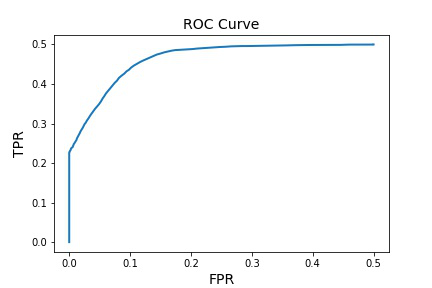

In [35]:
def _get_feature(feat_dir, suffix, ends_with='.npy'):
    return np.load(op.join(feat_dir, suffix) + ends_with)


feat_dir = './saved_features/ARFace/ir_se50_original/'
scores = []
for pair in ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs:
    p0_feat = _get_feature(feat_dir, pair[0]).squeeze(0)
    p1_feat = _get_feature(feat_dir, pair[1]).squeeze(0)
    scores.append(score_fn_original(p0_feat, p1_feat))
is_sames = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                    [False for _ in range(len(ARFace_sampler.negative_pairs))])
scores = np.array(scores)
acc = evaluate_and_plot(scores, is_sames, nrof_folds=10)
record_scores_and_acc(scores, acc, name='original_ArcFace')

In [36]:
def evaluate_our_model_ARFace(model_name, score_functions, score_names,
                              pairs, is_sames):
    def _get_feature(feat_dir, suffix, ends_with='.npz'):
        return np.load(op.join(feat_dir, suffix) + ends_with)
    
    learner.load_state(conf, f'{model_name}.pth', model_only=True, from_save_folder=True, strict=True, model_atten=True)
    learner.model.eval()
    learner.model_attention.eval()
    
    feat_dir = f'./saved_features/ARFace/{model_name}/'
    scores_dict = {score_name: [] for score_name in score_names}
    for pair in pairs:
        p0_feat = _get_feature(feat_dir, pair[0])['feat_map'].squeeze(0)
        p1_feat = _get_feature(feat_dir, pair[1])['feat_map'].squeeze(0)
        for score_name, score_fn in zip(score_names, score_functions):
            scores_dict[score_name].append(score_fn(p0_feat, p1_feat))
    
    for score_name in score_names:
        print(f'---- Name: {score_name} ----')
        scores = np.array(scores_dict[score_name]).squeeze()
        acc = evaluate_and_plot(scores, is_sames, nrof_folds=10)
        record_scores_and_acc(scores, acc, name=f'{model_name}_{score_name}')


model_names = [
    '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace',
    '2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None',
#     '2019-09-01-15-30_accuracy:0.9946666666666667_step:218346_CosFace',
#     '2019-08-25-14-35_accuracy:0.9931666666666666_step:218349_None',
]
score_names = [
    'uniform_weight', 'data_corr_stats', 'learned_weight', 
]
pairs = ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs
is_sames = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                    [False for _ in range(len(ARFace_sampler.negative_pairs))])

is_sames = 
for model_name in model_names:
    fixed_weight = np.load(f'/tmp3/biolin/data/insightFace_pytorch/{model_name}.npy')
    fixed_weight /= fixed_weight.sum()
    score_functions = [
        lambda p0_feat, p1_feat: score_fn_ours(p0_feat, p1_feat, learner, attention_strategy='uniform'),
        lambda p0_feat, p1_feat: score_fn_ours(p0_feat, p1_feat, learner, attention_strategy='fixed',
                                               attention_weight=fixed_weight),
        lambda p0_feat, p1_feat: score_fn_ours(p0_feat, p1_feat, learner, attention_strategy='learned'),
        
    ]
    print(f'====== Evaluating on our model ({model_name}) ======')
    evaluate_our_model_ARFace(model_name, score_functions, score_names, pairs, is_sames)
    print('\n')

SyntaxError: invalid syntax (<ipython-input-36-bca4ff6cfea9>, line 38)

In [ ]:
all_acc_ARFace = all_acc
all_scores_ARFace = all_scores

In [ ]:
df = pd.DataFrame(all_scores)

In [ ]:
to_plot_df = df.corr()[['original_ArcFace']]
to_plot_df = to_plot_df.rename(columns={'original_ArcFace': 'correlation'})
to_plot_df['accuracy'] = pd.DataFrame(all_acc, index=['accuracy']).T['accuracy']
to_plot_df
# sns.heatmap(to_plot_df, annot=True, fmt="f", )

In [30]:
df = pd.DataFrame(ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs)
df['is_same'] = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                         [False for _ in range(len(ARFace_sampler.negative_pairs))])
df = df.rename(columns={0: 'face1', 1: 'face2'})
df

,face1,face2,is_same
0,m-044-25,m-044-9,True
1,m-010-9,m-010-11,True
2,w-040-26,w-040-23,True
3,m-075-10,m-075-22,True
4,w-012-12,w-012-11,True
...,...,...,...
11995,w-034-9,m-004-24,False
11996,w-040-9,m-004-13,False
11997,m-045-8,m-033-11,False
11998,m-023-9,m-036-12,False


In [32]:
# df.to_csv("./saved_features/ARFace_pairs/1.csv")

In [12]:
to_plot_df = df.corr()[['original_ArcFace']]
to_plot_df = to_plot_df.rename(columns={'original_ArcFace': 'correlation'})
to_plot_df['accuracy'] = pd.DataFrame(all_acc, index=['accuracy']).T['accuracy']
to_plot_df
# sns.heatmap(to_plot_df, annot=True, fmt="f", )

,correlation,accuracy
original_ArcFace,1.000000,0.822417
2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace_uniform_weight,0.970318,0.850583
2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace_data_corr_stats,0.970324,0.858667
2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace_learned_weight,0.970339,0.841500
2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None_uniform_weight,0.974512,0.816417
2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None_data_corr_stats,0.974649,0.815500
2019-08-30-07-36_accuracy:0.9953333333333333_step:655047_None_learned_weight,0.964821,0.825500


In [19]:
df = pd.DataFrame(ARFace_sampler.positive_pairs + ARFace_sampler.negative_pairs)
df['is_same'] = np.array([True for _ in range(len(ARFace_sampler.positive_pairs))] +
                         [False for _ in range(len(ARFace_sampler.negative_pairs))])
df

,0,1,is_same
0,w-016-23,w-016-11,True
1,m-043-22,m-043-9,True
2,m-005-10,m-005-22,True
3,m-005-23,m-005-8,True
4,w-050-25,w-050-26,True
...,...,...,...
11995,m-054-25,m-065-25,False
11996,w-044-24,w-049-8,False
11997,m-048-8,m-036-21,False
11998,m-008-13,m-010-10,False


# Evaluate on IJB-C

In [4]:
loader = torch.utils.data.DataLoader(
    IJBCVerificationPathDataset('/tmp3/zhe2325138/IJB/IJB-C/', occlusion_lower_bound=1, leave_ratio=0.002),
    batch_size=1, shuffle=False
)
len(loader)

31316

In [5]:
def _get_feature_original(feat_dir, suffixes, ends_with='.npy'):
    return np.concatenate([
        np.load(op.join(feat_dir, suffix[0]) + ends_with)
        for suffix in suffixes
    ], axis=0)


def _get_feature_ours(feat_dir, suffixes, ends_with='.npz'):
#     print(op.join(feat_dir, suffixes[0][0]) + ends_with)
    return np.concatenate([
        np.load(op.join(feat_dir, suffix[0]) + ends_with)['feat_map']
        for suffix in suffixes
    ], axis=0)


def run_IJBC_verification(loader, feat_dir, compare_strategy, _get_feature, score_fn, score_fn_kargs,
                          learner=None, attention_strategy=None):
    assert compare_strategy in ['compare_only_first_img', 'mean_comparison']
    is_sames = []
    scores = []
    init_time = time.time()
    ignored_count = 0
    for i, pair in enumerate(loader):
        if i % 1000 == 0:
            print(f"Processing match {i}, elapsed {time.time() - init_time:.1f} seconds")
        if len(pair['enroll_path_suffixes']) == 0 or len(pair['verif_path_suffixes']) == 0:
            ignored_count += 1
            continue

        if compare_strategy == 'compare_only_first_img':
            enroll_feature = _get_feature(feat_dir, pair['enroll_path_suffixes'][:1]).squeeze(0)
            verif_feature = _get_feature(feat_dir, pair['verif_path_suffixes'][:1]).squeeze(0)
        elif compare_strategy == 'mean_comparison':
            enroll_feature = _get_feature(feat_dir, pair['enroll_path_suffixes']).mean(axis=0)
            verif_feature = _get_feature(feat_dir, pair['verif_path_suffixes']).mean(axis=0)
        else:
            raise NotImplementedError
        score = score_fn(enroll_feature, verif_feature, **score_fn_kargs)
        scores.append(score)
        is_sames.append(pair['is_same'].cpu().numpy().astype(np.bool))
    
    print(f'{ignored_count} pairs are ignored since one of the template has no valid image.')
    scores = np.array(scores).squeeze()
    is_sames = np.array(is_sames).squeeze().astype(np.bool)
    return scores, is_sames

In [6]:
all_scores = {}
all_acc = {}

def record_scores_and_acc(scores, acc, name, name2=None):
    all_scores[name] = scores
    all_acc[name] = acc

In [ ]:
scores, is_sames = run_IJBC_verification(
    loader, feat_dir='./saved_features/IJB-C/ir_se50_original/',
    score_fn=score_fn_original, _get_feature=_get_feature_original,
    compare_strategy='compare_only_first_img', score_fn_kargs={}
)
acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')
all_scores['original_ArcFace'] = scores
all_acc['original_ArcFace'] = acc

In [ ]:
model_name = '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace'
fixed_weight = np.load(f'/tmp3/biolin/data/insightFace_pytorch/{model_name}.npy')
fixed_weight /= fixed_weight.sum()

for attention_strategy in ['uniform', 'learned', 'fixed']:
    print(f'===== attention_strategy: {attention_strategy} =====')
    scores, is_sames = run_IJBC_verification(
        loader, feat_dir=f'./saved_features/IJB-C/{model_name}',
        score_fn=score_fn_ours, _get_feature=_get_feature_ours,
        compare_strategy='compare_only_first_img',
        score_fn_kargs={'learner': learner, 'attention_strategy': attention_strategy,
                        'attention_weight': fixed_weight}
    )
    acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')

    all_scores[f'{model_name}_{attention_strategy}'] = scores
    all_acc[f'{model_name}_{attention_strategy}'] = acc

In [ ]:
all_scores

In [ ]:
all_acc

# IJB-A

In [4]:
all_scores = {}
all_acc = {}

def record_scores_and_acc(scores, acc, name, name2=None):
    all_scores[name] = scores
    all_acc[name] = acc
    
shuffle_order = np.arange(len(IJBAVerificationDataset()))
np.random.shuffle(shuffle_order)

In [5]:
'''
For IJB-A, I save features of t1 and t2 "for each comparison" and the corresponding label (is same or not)
'''
def _get_feature(fname):
    npz = np.load(fname)
    return npz['f1'], npz['f2'], npz['same']

def run_IJBA_verification(feat_dir, score_fn, score_fn_kargs, shuffle_order,
                          learner=None, attention_strategy=None, ):
    is_sames = []
    scores = []
    init_time = time.time()
    fnames = sorted(glob(op.join(feat_dir, '*.npz')))
    fnames = [fnames[i] for i in shuffle_order]
    print(len(fnames))
    for i, fname in enumerate(fnames):
        if i % 500 == 0:
            print(f"Processing match {i}, elapsed {time.time() - init_time:.1f} seconds")
        f1, f2, is_same = _get_feature(fname)
        score = score_fn(f1, f2, **score_fn_kargs)
        score = score.cpu().numpy() if torch.is_tensor(score) else score
        scores.append(score)
        is_sames.append(is_same.astype(np.bool))
    
    scores = np.array(scores).squeeze()
    is_sames = np.array(is_sames).squeeze().astype(np.bool)
    return scores, is_sames

11787
Processing match 0, elapsed 0.1 seconds
Processing match 500, elapsed 1.0 seconds
Processing match 1000, elapsed 2.0 seconds
Processing match 1500, elapsed 3.1 seconds
Processing match 2000, elapsed 3.9 seconds
Processing match 2500, elapsed 4.7 seconds
Processing match 3000, elapsed 5.7 seconds
Processing match 3500, elapsed 6.5 seconds
Processing match 4000, elapsed 7.6 seconds
Processing match 4500, elapsed 8.4 seconds
Processing match 5000, elapsed 9.2 seconds
Processing match 5500, elapsed 10.2 seconds
Processing match 6000, elapsed 11.1 seconds
Processing match 6500, elapsed 12.2 seconds
Processing match 7000, elapsed 13.1 seconds
Processing match 7500, elapsed 14.0 seconds
Processing match 8000, elapsed 15.0 seconds
Processing match 8500, elapsed 15.8 seconds
Processing match 9000, elapsed 16.8 seconds
Processing match 9500, elapsed 17.8 seconds
Processing match 10000, elapsed 18.7 seconds
Processing match 10500, elapsed 19.7 seconds
Processing match 11000, elapsed 20.8 se

/home/master/07/zhe2325138/miniconda3/envs/xCos/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


(array([ 222, 1772, 3885, 2929, 1614,  808,  388,  140,   22,    7]), array([-0.22281604, -0.10495416,  0.01290771,  0.13076958,  0.24863145,
        0.3664933 ,  0.48435518,  0.6022171 ,  0.72007895,  0.8379408 ,
        0.9558027 ], dtype=float32)) (array([9984,    0,    0,    0,    0,    0,    0,    0,    0, 1803]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
IJBC - accuray:0.86332 (1-0.13668), threshold:0.49500000000000133


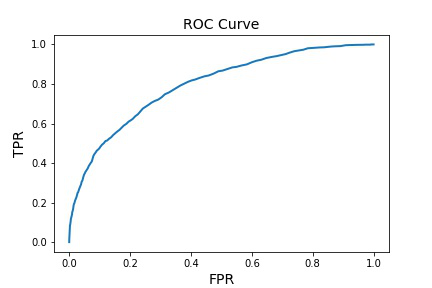

In [6]:
scores, is_sames = run_IJBA_verification(
    feat_dir='./saved_features/IJB-A/split1/ir_se50/',
    score_fn=score_fn_original, score_fn_kargs={},
    shuffle_order=shuffle_order
)
print(np.histogram(scores), np.histogram(is_sames))
acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')
all_scores['original_ArcFace'] = scores
all_acc['original_ArcFace'] = acc

In [9]:
for far_target in [1e-1, 1e-2, 1e-3]:
    mean_tar = calculate_val_by_diff(
        thresholds='default', dist=(1 - scores), actual_issame=is_sames, far_target=0.001, ret_acc=True,
        nrof_folds=5
    )[0]
    print("TAR@FAR{far_target:.f}:{mean_tar}")
# calculate_val_far()

(0.040202767868084396,
 0.0076006814510782335,
 0.00099817810864775,
 0.8523798059881903,
 0.005383359447112312)

In [ ]:
evaluate_and_plot_roc

===== attention_strategy: uniform =====
11787
Processing match 0, elapsed 0.1 seconds
Processing match 500, elapsed 4.2 seconds
Processing match 1000, elapsed 8.6 seconds
Processing match 1500, elapsed 13.1 seconds
Processing match 2000, elapsed 17.4 seconds
Processing match 2500, elapsed 21.3 seconds
Processing match 3000, elapsed 25.3 seconds
Processing match 3500, elapsed 29.5 seconds
Processing match 4000, elapsed 34.4 seconds
Processing match 4500, elapsed 38.9 seconds
Processing match 5000, elapsed 43.3 seconds
Processing match 5500, elapsed 47.3 seconds
Processing match 6000, elapsed 52.1 seconds
Processing match 6500, elapsed 56.2 seconds
Processing match 7000, elapsed 59.9 seconds
Processing match 7500, elapsed 64.1 seconds
Processing match 8000, elapsed 68.5 seconds
Processing match 8500, elapsed 72.7 seconds
Processing match 9000, elapsed 76.9 seconds
Processing match 9500, elapsed 81.1 seconds
Processing match 10000, elapsed 85.8 seconds
Processing match 10500, elapsed 90.0

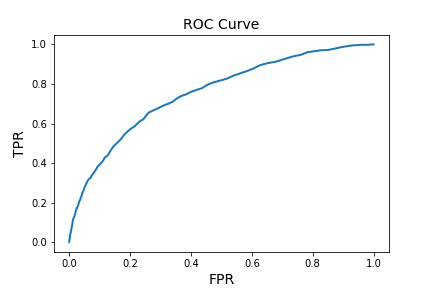

===== attention_strategy: learned =====
11787
Processing match 0, elapsed 0.2 seconds
Processing match 500, elapsed 8.8 seconds
Processing match 1000, elapsed 13.4 seconds
Processing match 1500, elapsed 18.2 seconds
Processing match 2000, elapsed 23.0 seconds
Processing match 2500, elapsed 27.4 seconds
Processing match 3000, elapsed 32.6 seconds
Processing match 3500, elapsed 37.3 seconds
Processing match 4000, elapsed 42.1 seconds
Processing match 4500, elapsed 46.6 seconds
Processing match 5000, elapsed 51.4 seconds
Processing match 5500, elapsed 56.2 seconds
Processing match 6000, elapsed 60.7 seconds
Processing match 6500, elapsed 65.7 seconds
Processing match 7000, elapsed 70.7 seconds
Processing match 7500, elapsed 75.4 seconds
Processing match 8000, elapsed 79.9 seconds
Processing match 8500, elapsed 84.4 seconds
Processing match 9000, elapsed 88.9 seconds
Processing match 9500, elapsed 93.6 seconds
Processing match 10000, elapsed 98.7 seconds
Processing match 10500, elapsed 103

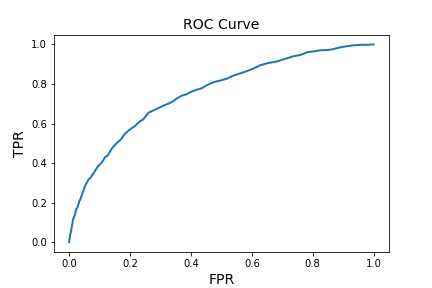

===== attention_strategy: fixed =====
11787
Processing match 0, elapsed 0.2 seconds
Processing match 500, elapsed 4.5 seconds
Processing match 1000, elapsed 9.3 seconds
Processing match 1500, elapsed 13.6 seconds
Processing match 2000, elapsed 18.3 seconds
Processing match 2500, elapsed 22.3 seconds
Processing match 3000, elapsed 26.4 seconds
Processing match 3500, elapsed 30.9 seconds
Processing match 4000, elapsed 35.0 seconds
Processing match 4500, elapsed 38.6 seconds
Processing match 5000, elapsed 42.7 seconds
Processing match 5500, elapsed 46.6 seconds
Processing match 6000, elapsed 50.6 seconds
Processing match 6500, elapsed 55.1 seconds
Processing match 7000, elapsed 59.2 seconds
Processing match 7500, elapsed 63.6 seconds
Processing match 8000, elapsed 67.6 seconds
Processing match 8500, elapsed 72.5 seconds
Processing match 9000, elapsed 76.6 seconds
Processing match 9500, elapsed 80.5 seconds
Processing match 10000, elapsed 85.3 seconds
Processing match 10500, elapsed 89.2 s

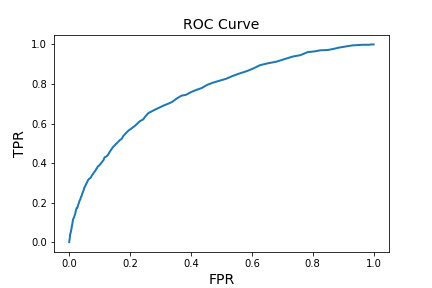

In [11]:
model_name = '2019-09-02-08-21_accuracy:0.9968333333333333_step:436692_CosFace'
fixed_weight = np.load(f'/tmp3/biolin/data/insightFace_pytorch/{model_name}.npy')
fixed_weight /= fixed_weight.sum()

for attention_strategy in ['uniform', 'learned', 'fixed']:
    print(f'===== attention_strategy: {attention_strategy} =====')
    scores, is_sames = run_IJBA_verification(
        feat_dir=f'./saved_features/IJB-A/split1/{model_name}',
        score_fn=score_fn_ours,
        score_fn_kargs={'learner': learner, 'attention_strategy': attention_strategy,
                        'attention_weight': fixed_weight},
        shuffle_order=shuffle_order
    )
    acc = evaluate_and_plot(scores, is_sames, nrof_folds=10, dataset_name='IJBC')

    all_scores[f'{model_name}_{attention_strategy}'] = scores
    all_acc[f'{model_name}_{attention_strategy}'] = acc

# The following codes are just testing
## Evaluate on LFW (just testing)

In [7]:
def getUnitAttention():
    x = torch.ones(conf.batch_size//2, 1, 7, 7).cuda()
    x /= x.flatten(2).sum(dim=2).repeat(1, 1, x.size(2) * x.size(3)).view_as(x)
    return x
unit_attention = getUnitAttention()
unit_attention.size()

torch.Size([10, 1, 7, 7])

In [8]:
lfw, lfw_issame = get_val_pair(conf.emore_folder, 'lfw')
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)
learner.model.eval()
learner.model.returnGrid = True  # Remember to reset this before return!
learner.model_attention.eval()

AttentionXCosNet(
  (embedding_net): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (attention): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
  )
)

## Our models (wo/w attention)

In [9]:
# %%time
# accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
#     conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=unit_attention
# )
# print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
# trans.ToPILImage()(roc_curve_tensor)

In [10]:
# %%time
# accuracy, best_threshold, roc_curve_tensor = learner.evaluate_attention(
#     conf, lfw, lfw_issame, nrof_folds=10, tta=True, attention=None
# )
# print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
# trans.ToPILImage()(roc_curve_tensor)

## The original model

lfw - accuray:0.9953333333333333, threshold:0.28250000000000103
CPU times: user 17min 45s, sys: 42.8 s, total: 18min 28s
Wall time: 1min 44s


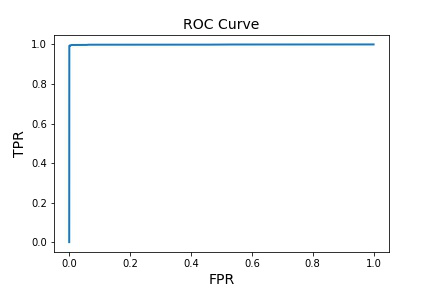

In [11]:
%%time
learner.load_state(conf, 'ir_se50.pth', model_only=True, from_save_folder=True, strict=False, model_atten=False)
cosines = learner.get_original_cosines(lfw, conf, tta=True)
accuracy, best_threshold, roc_curve_tensor = learner.evaluate_and_plot_roc(cosines, lfw_issame, nrof_folds=10)
print('lfw - accuray:{}, threshold:{}'.format(accuracy, best_threshold))
trans.ToPILImage()(roc_curve_tensor)

In [50]:
calculate_val_by_diff(
    thresholds='default', dist=(1 - cosines), actual_issame=lfw_issame,
    far_target=0.001, ret_acc=True)

(0.9933333333333334,
 0.006146362971528595,
 0.0013333333333333335,
 0.9959999999999999,
 0.0027080128015453224)

In [29]:
calculate_val_far((1 - 0.28250000000000103), (1 - cosines), lfw_issame, ret_acc=True)

(0.9936666666666667, 0.002, 0.9958333333333333)